## Подготовка

In [1]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import pandas as pd
import pythonUtils.config as config
import pythonUtils.drawing as drawing
import pythonUtils.metrics as metrics

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.random.seed = random_seed

In [3]:
s = config.get_s()
train_dataset = torch.load(f"datasets/train{s}.pt")
test_dataset = torch.load(f"datasets/test{s}.pt")
result_dataset = torch.load(f"datasets/predict{s}.pt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
train_dataloader_out = torch.utils.data.DataLoader(train_dataset, batch_size= 1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_dataloader_out = torch.utils.data.DataLoader(test_dataset, batch_size= 1)

In [4]:
len(train_dataset)

6296

In [5]:
len(test_dataset)

2699

In [6]:

class CatNet(nn.Module):
    def __init__(self, inputsize, outputsize):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 10, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),

            torch.nn.Conv2d(16, 32, 5, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),

            torch.nn.Conv2d(32, 64, 5, stride=1),
            torch.nn.ReLU(),
    
            torch.nn.MaxPool2d(2),

            torch.nn.BatchNorm2d(64),

            torch.nn.Dropout2d(),

            torch.nn.Conv2d(64, 128, 5, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.Dropout2d(),

            torch.nn.AvgPool2d(2),
            torch.nn.Conv2d(128, 256, 5, stride=1),
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(2),

            torch.nn.BatchNorm2d(256),

            torch.nn.Flatten(),
            torch.nn.Linear(2304, 1024),
            torch.nn.Sigmoid(),
            torch.nn.Linear(1024, 18)
        ) 
    def forward(self, x):
        return self.model(x)


In [7]:
num_epochs = 60
learning_rate = 4e-3
model = CatNet(16, 18)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
loss_history = []
epoch_loss_history = []

## Обучение

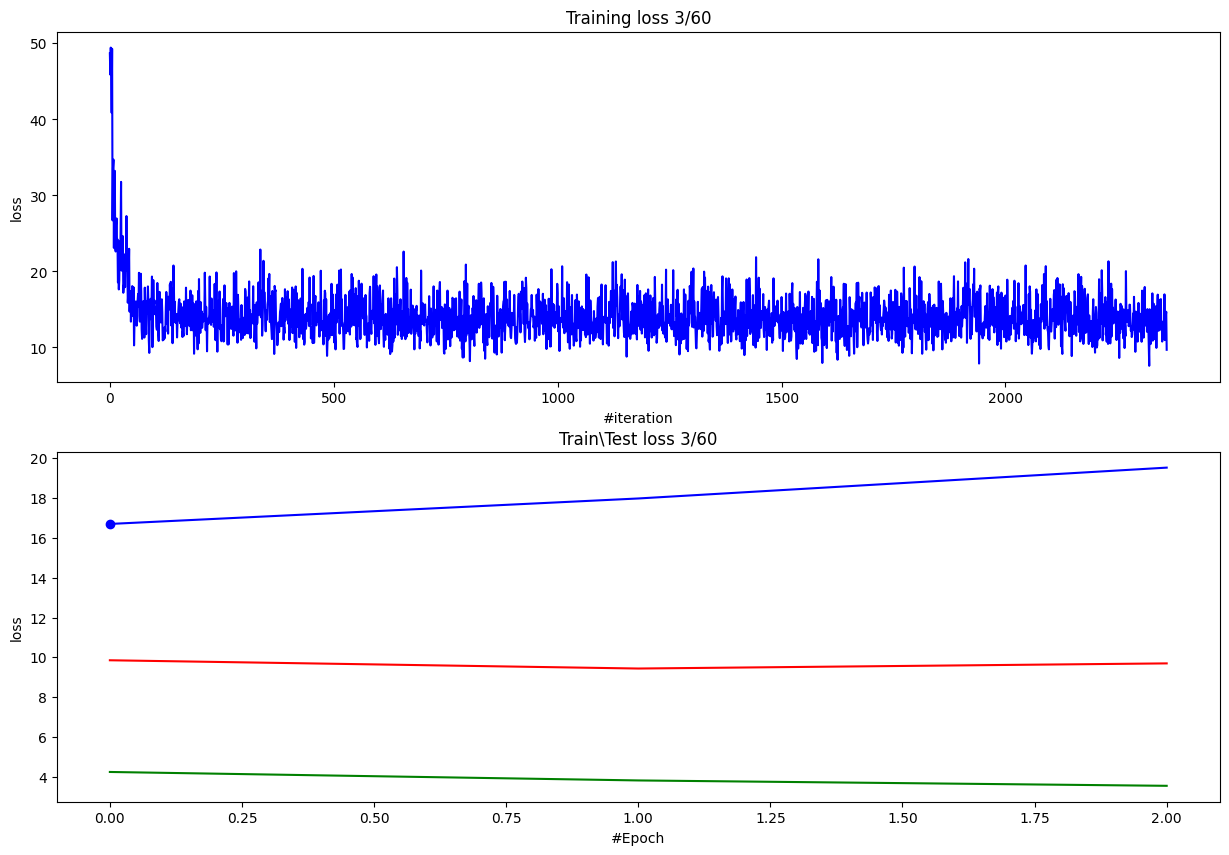

1/60 current loss: 9.853940963745117 | train: 4.2410873836941185 | test: 16.704008797804516
2/60 current loss: 9.438894271850586 | train: 3.815413581000434 | test: 17.984189993805355
3/60 current loss: 9.697006225585938 | train: 3.545369995964898 | test: 19.533886439270443


KeyboardInterrupt: 

In [8]:
calculate_train_mae = True
train_mae = []
test_mae = []
best_ = None
best_test_mae = 10000
best_test_mae_epoch = -1
strings = []
for i in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        predictions = model.forward(x_batch)
        
        loss = criterion(predictions, y_batch)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad() 

        loss_history.append(loss.item())
    torch.save(model.state_dict(), f"checkpoints/{i+1}_{num_epochs}.pth")
    epoch_loss_history.append(loss.item())
    fig, axs = plt.subplots(nrows= 2, ncols= 1,  figsize=(15,10))
    display.clear_output(wait=True)

    axs[0].set_title(f"Training loss {i+1}/{num_epochs}")
    axs[0].set_xlabel("#iteration")
    axs[0].set_ylabel("loss")
    axs[0].plot(loss_history, 'b')
    
    axs[1].set_title(f"Epoch loss {i+1}/{num_epochs}")
    axs[1].set_xlabel("#Epoch")
    axs[1].set_ylabel("loss")
    axs[1].plot(epoch_loss_history, 'r')
    temp_test_mae = metrics.mae(test_dataloader_out, model)
    test_mae.append(temp_test_mae)
    if temp_test_mae < best_test_mae:
        best_test_mae = temp_test_mae
        best_ = model.state_dict()
        best_test_mae_epoch = i
    axs[1].set_title(f"Test loss {i+1}/{num_epochs}")
    axs[1].set_xlabel("#Epoch")
    axs[1].set_ylabel("loss")
    axs[1].plot(test_mae, 'b', label = 'test')
    axs[1].plot(best_test_mae_epoch, best_test_mae, 'bo')
    temp_train_mae = 0
    if calculate_train_mae:
        temp_train_mae = metrics.mae(train_dataloader_out, model)
        train_mae.append(temp_train_mae)

        axs[1].set_title(f"Train\Test loss {i+1}/{num_epochs}")
        axs[1].plot(train_mae, 'g', label = 'train')
    plt.show()
    strings.append(f'{i+1}/{num_epochs} current loss: {epoch_loss_history[i]} | train: {temp_train_mae} | test: {temp_test_mae}')
    for s in strings:
          print(s) 
torch.save(model.state_dict(), 'weights/CatNet.pth')

In [9]:
model = CatNet(16, 18)
#model.load_state_dict(torch.load('weights/CatNet.pth'))
model.load_state_dict(torch.load('checkpoints/2_60.pth'))
model.eval()
""

''

## Оценка

In [10]:
print(f"MAE on train data : {metrics.mae(train_dataloader_out, model)}")
print(f"MAE on test data : {metrics.mae(test_dataloader_out, model)}")

#print(f"CMAE on train data : {metrics.cmae(train_dataloader_out, model)}")
#print(f"CMAE on test data : {metrics.cmae(test_dataloader_out, model)}")

MAE on train data : 4.511837323506673
MAE on test data : 17.723871608575184


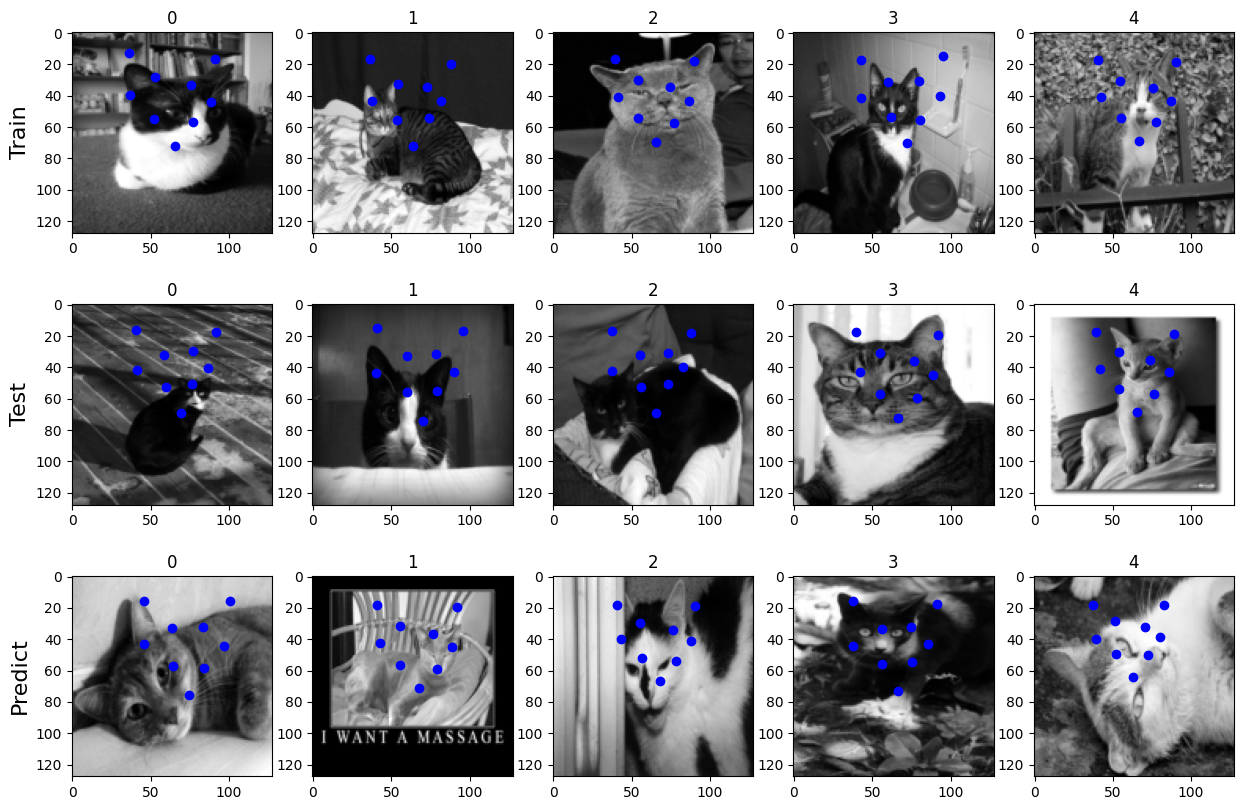

In [11]:
fig, axs = plt.subplots(nrows= 3 , ncols= 5,  figsize=(15,10))
drawing.draw_pred_line(axs, train_dataset, model, 'Train', 0, 5)
drawing.draw_pred_line(axs, test_dataset, model, 'Test', 1, 5)
drawing.draw_pred_line(axs, result_dataset, model, 'Predict', 2, 5)
plt.show()

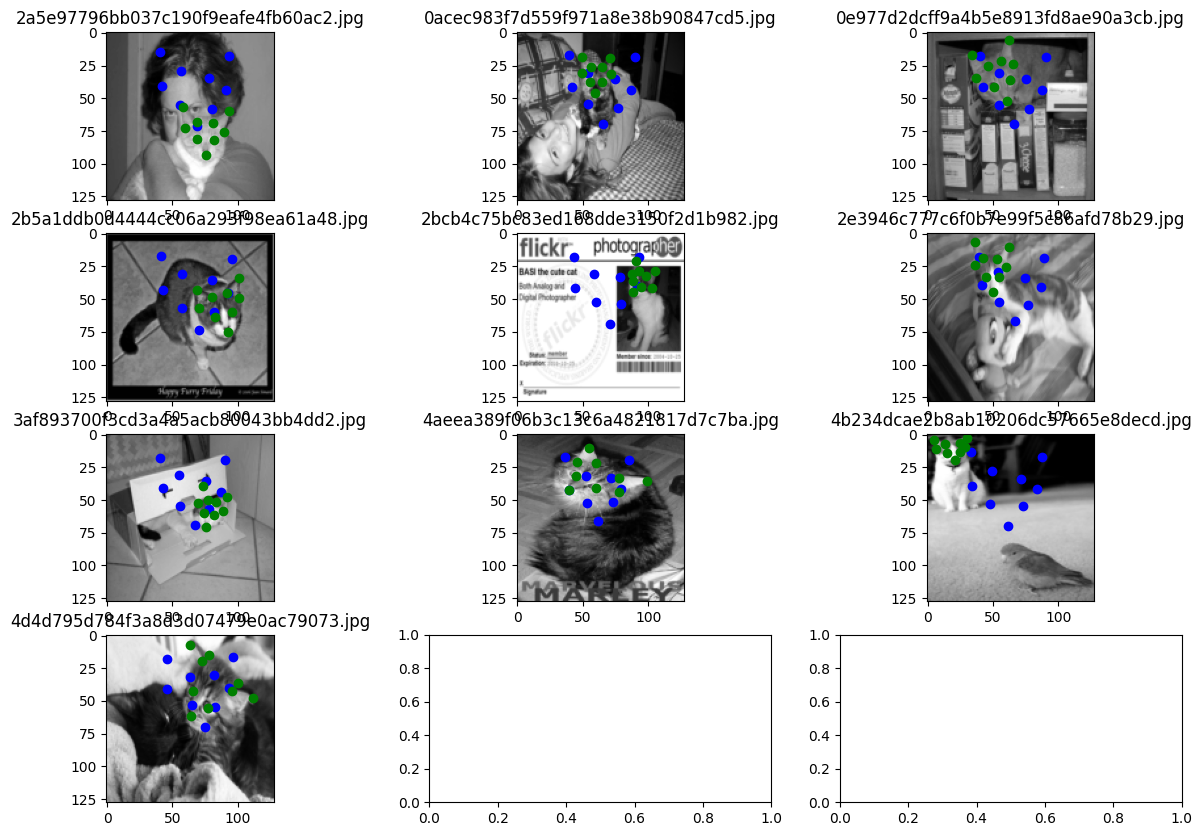

In [12]:
#from pythonUtils.drawing import draw_img_by_name
from pythonUtils.config import intresting_pictures
fig, axs = plt.subplots(nrows= (len(intresting_pictures)//3)+1, ncols= 3,  figsize=(15,10))

for i in range(len(intresting_pictures)):
    drawing.draw_img_by_name(intresting_pictures[i], model, axs[i//3,i%3])

## Подсчет результатов

In [13]:
result_dataloader_1 = torch.utils.data.DataLoader(result_dataset)
pred = []
for x in result_dataloader_1:
    preds = model.forward(x[0])
    pred.append(preds[0].tolist())
predSizesNames = pd.read_csv('datasets/predictSizez&names.csv')
columns = pd.read_csv('train_labels.csv').columns
result = pd.DataFrame(columns=columns)
for row in range(len(pred)):
    width = predSizesNames.loc[row,'0']
    height = predSizesNames.loc[row,'0']
    for i in range(0, len(pred[row]),2):
            pred[row][i] = pred[row][i]*(width/config.size)
            pred[row][i+1] = pred[row][i+1]*(height/config.size)
for row in range(len(pred)):
    result.loc[-1] = pred[row]+[predSizesNames.loc[row,'2']]
    result.index = result.index + 1
    result = result.sort_index()
result = result.rename(columns={"file_name":"file_names"})
result.to_csv('results/result.csv',index=False)